In [31]:
import yfinance as yf

# Fetch historical data for Google (GOOGL)
data_google = yf.download("GOOGL", start="2015-01-01", end="2023-01-01")
data_google.reset_index(inplace=True)
print(data_google.head())
type(data_google)
data_google.columns

[*********************100%***********************]  1 of 1 completed

Price                       Date  Adj Close      Close       High        Low  \
Ticker                                GOOGL      GOOGL      GOOGL      GOOGL   
0      2015-01-02 00:00:00+00:00  26.381865  26.477501  26.790001  26.393999   
1      2015-01-05 00:00:00+00:00  25.879185  25.973000  26.399500  25.887501   
2      2015-01-06 00:00:00+00:00  25.240501  25.332001  26.060499  25.277500   
3      2015-01-07 00:00:00+00:00  25.166269  25.257500  25.574499  25.182501   
4      2015-01-08 00:00:00+00:00  25.253954  25.345501  25.375000  24.750999   

Price        Open    Volume  
Ticker      GOOGL     GOOGL  
0       26.629999  26480000  
1       26.357500  41182000  
2       26.025000  54456000  
3       25.547501  46918000  
4       25.075500  73054000  


MultiIndex([(     'Date',      ''),
            ('Adj Close', 'GOOGL'),
            (    'Close', 'GOOGL'),
            (     'High', 'GOOGL'),
            (      'Low', 'GOOGL'),
            (     'Open', 'GOOGL'),
            (   'Volume', 'GOOGL')],
           names=['Price', 'Ticker'])

In [32]:
data_google = data_google.reset_index()
print(data_google['Date'].head())
data_googledata_google = data_google.reset_index()
data_google.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in data_google.columns]
if 'index' in data_google.columns:
    data_google = data_google.drop('index', axis=1)

# Create time index and add group identifier
data_google['time'] = range(len(data_google))
data_google['group'] = 'GOOGL'
data_google.columns

0   2015-01-02 00:00:00+00:00
1   2015-01-05 00:00:00+00:00
2   2015-01-06 00:00:00+00:00
3   2015-01-07 00:00:00+00:00
4   2015-01-08 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


Index(['Date', 'Adj Close_GOOGL', 'Close_GOOGL', 'High_GOOGL', 'Low_GOOGL',
       'Open_GOOGL', 'Volume_GOOGL', 'time', 'group'],
      dtype='object')

In [33]:
# --- Data Quality Improvements Begin Here ---

# Check if 'Date' is in columns; if not, reset the index again
if 'Date' not in data_google.columns:
    data_google.reset_index(inplace=True)
    print("After resetting index, columns:", data_google.columns)

# Convert 'Date' to datetime
data_google['Date'] = pd.to_datetime(data_google['Date'])

# Continue with sorting and further cleaning
data_google.sort_values('Date', inplace=True)
data_google.reset_index(drop=True, inplace=True)

# Check for missing values and fill them
print("Missing values per column:")
print(data_google.isnull().sum())
data_google.fillna(method='ffill', inplace=True)

# Remove duplicate rows
data_google.drop_duplicates(inplace=True)

# Outlier removal (example for key numerical columns)
from scipy import stats
import numpy as np
for col in ['Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL']:
    z_scores = np.abs(stats.zscore(data_google[col]))
    data_google = data_google[z_scores < 3]

# Feature engineering: Extract additional date features
data_google['year'] = data_google['Date'].dt.year
data_google['month'] = data_google['Date'].dt.month
data_google['day'] = data_google['Date'].dt.day
data_google['weekday'] = data_google['Date'].dt.weekday
data_google['month_sin'] = np.sin(2 * np.pi * data_google['month'] / 12)
data_google['month_cos'] = np.cos(2 * np.pi * data_google['month'] / 12)
data_google['weekday_sin'] = np.sin(2 * np.pi * data_google['weekday'] / 7)
data_google['weekday_cos'] = np.cos(2 * np.pi * data_google['weekday'] / 7)

# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
num_cols = ['Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL']
scaler = MinMaxScaler()
data_google[num_cols] = scaler.fit_transform(data_google[num_cols])

print("Data quality improvements complete.")
print(data_google.head())


Missing values per column:
Date               0
Adj Close_GOOGL    0
Close_GOOGL        0
High_GOOGL         0
Low_GOOGL          0
Open_GOOGL         0
Volume_GOOGL       0
time               0
group              0
dtype: int64
Data quality improvements complete.
                       Date  Adj Close_GOOGL  Close_GOOGL  High_GOOGL  \
0 2015-01-02 00:00:00+00:00        26.381865     0.012998    0.014101   
1 2015-01-05 00:00:00+00:00        25.879185     0.008961    0.011000   
2 2015-01-06 00:00:00+00:00        25.240501     0.003832    0.008309   
3 2015-01-07 00:00:00+00:00        25.166269     0.003236    0.004450   
4 2015-01-08 00:00:00+00:00        25.253954     0.003940    0.002866   

   Low_GOOGL  Open_GOOGL  Volume_GOOGL  time  group  year  month  day  \
0   0.014865    0.013343      0.214337     0  GOOGL  2015      1    2   
1   0.010792    0.011163      0.397888     1  GOOGL  2015      1    5   
2   0.005886    0.008503      0.563610     2  GOOGL  2015      1    6   
3   

C:\Users\deepa\AppData\Local\Temp\ipykernel_23788\3376216897.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_google.fillna(method='ffill', inplace=True)


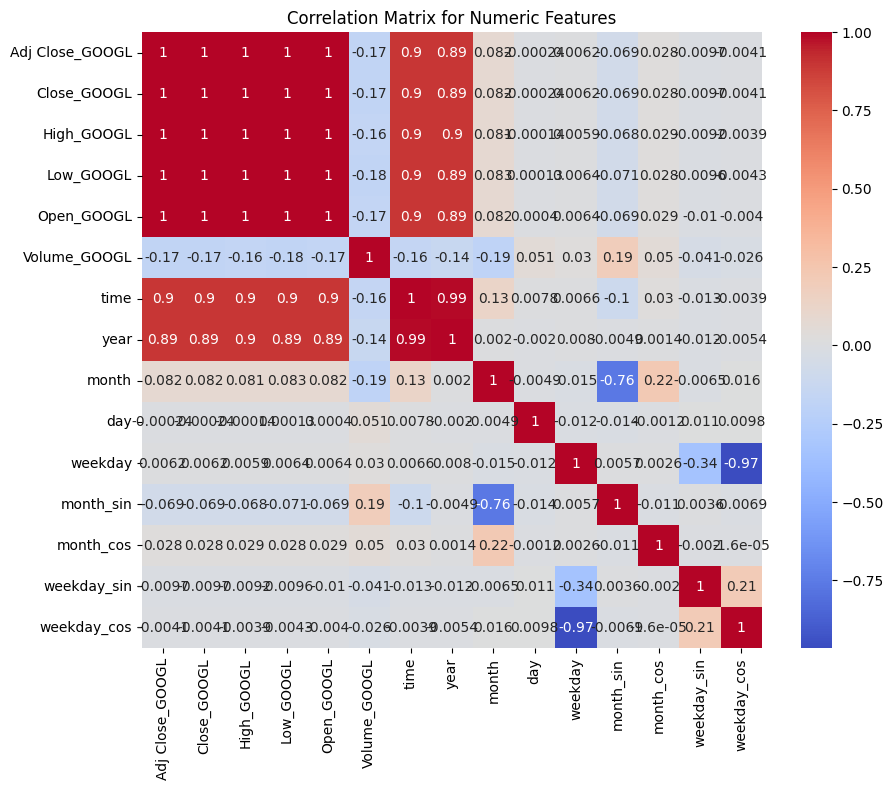

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_data = data_google.select_dtypes(include=[float, int])

# Compute the correlation matrix for numeric features
corr_matrix = numeric_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()


In [35]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
# Adjust feature_cols as needed, for example including engineered date features
X = data_google[['High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL', 'year', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']]
y = data_google['Close_GOOGL']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Lasso with cross-validation to perform feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Examine coefficients
feature_importance = pd.Series(lasso.coef_, index=X.columns)
print("Lasso coefficients:\n", feature_importance)


Lasso coefficients:
 High_GOOGL      0.757975
Low_GOOGL       0.209381
Open_GOOGL      0.000000
Volume_GOOGL   -0.000000
year            0.003041
month_sin      -0.000000
month_cos       0.000000
weekday_sin    -0.000000
weekday_cos    -0.000000
dtype: float64


c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.364e-02, tolerance: 1.138e-02
  model = cd_fast.enet_coordinate_descent(


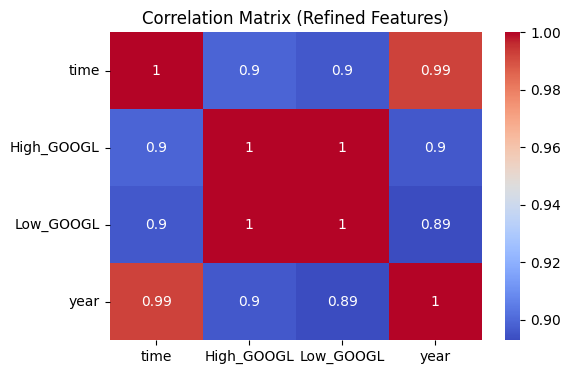

In [36]:
# Create a refined DataFrame with only the significant features:
selected_features = ['High_GOOGL', 'Low_GOOGL', 'year']  # Add any additional features if needed
refined_data = data_google[['Date', 'time', 'group'] + selected_features].copy()

# Optionally, if you want to keep some engineered date features (if they add value):
# refined_data = data_google[['Date', 'time', 'group', 'High_GOOGL', 'Low_GOOGL', 'year', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']]
import seaborn as sns
import matplotlib.pyplot as plt

numeric_refined = refined_data.select_dtypes(include=[float, int])
corr_matrix_refined = numeric_refined.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_refined, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Refined Features)")
plt.show()


In [38]:
# Create a refined DataFrame that includes only the selected features and target
selected_features = ['High_GOOGL', 'Low_GOOGL', 'year']
refined_data = data_google[['Date', 'time', 'group', 'Close_GOOGL'] + selected_features].copy()

from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

# Define the maximum encoder and prediction lengths
max_encoder_length = 120  # Use the past 120 time steps as input
max_prediction_length = 30  # Predict the next 30 time steps

# Determine the training cutoff point
training_cutoff = refined_data["time"].max() - max_prediction_length

# Create the TimeSeriesDataSet
training_dataset = TimeSeriesDataSet(
    refined_data[refined_data["time"] <= training_cutoff],
    time_idx="time",
    target="Close_GOOGL",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    static_reals=["year"],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=["time"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["High_GOOGL", "Low_GOOGL", "Close_GOOGL"],
    target_normalizer=GroupNormalizer(
        groups=["group"],
        transformation="softplus"  # or "standard", depending on your data distribution
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True  # Allow missing time steps
)

# Define the batch size
batch_size = 128  # Adjust based on your hardware

# Create the validation dataset
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    refined_data, 
    predict=True, 
    stop_randomization=True
)

# Create dataloaders
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [44]:
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
import lightning.pytorch as pl

# Initialize the TFT model
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.03,
    hidden_size=16,  # You can adjust this value based on your dataset size and complexity
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,  # Typically <= hidden_size
    loss=QuantileLoss(),  # For probabilistic forecasting; adjust quantiles if needed
    optimizer="adam",
    reduce_on_plateau_patience=4,
)

# Print the model size (optional)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

# Set up PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",  # Use "gpu" if available
    gradient_clip_val=0.1,
)

# Train the model
trainer.fit(tft, train_dataloader, val_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 144    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 2.4 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.0 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork 

Number of parameters in network: 20.6k
Epoch 49: 100%|██████████| 13/13 [00:05<00:00,  2.37it/s, v_num=40, train_loss_step=0.0106, val_loss=0.0145, train_loss_epoch=0.0102] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 13/13 [00:05<00:00,  2.32it/s, v_num=40, train_loss_step=0.0106, val_loss=0.0145, train_loss_epoch=0.0102]


c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


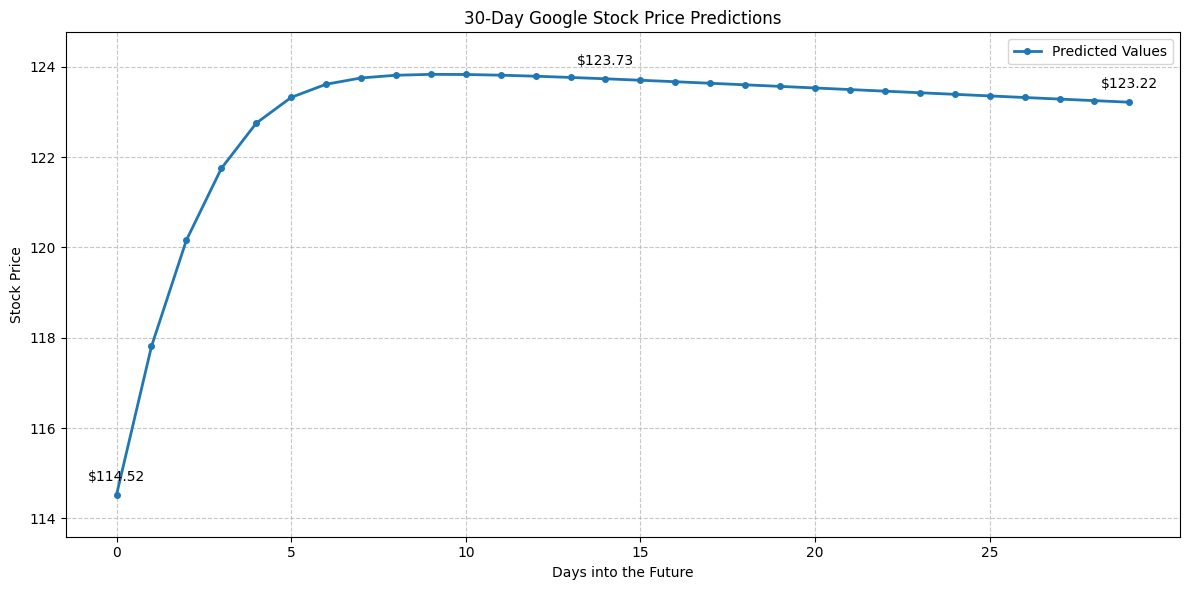


Prediction Statistics:
Starting price: $114.52
Ending price: $123.22
Price range: $9.31


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Set model to evaluation mode
tft.eval()

with torch.no_grad():
    # Get predictions using the model's predict method  
    predictions = tft.model.predict(val_dataloader)

# Convert predictions to numpy
predictions_np = predictions.numpy()

# Create time steps for x-axis (30 days into the future)
future_time_steps = np.arange(30)

# Plot the predictions
plt.figure(figsize=(12, 6))

# Plot predictions
plt.plot(future_time_steps, predictions_np[0, :], 
         marker='o', label='Predicted Values', 
         linewidth=2, markersize=4)

plt.title('30-Day Google Stock Price Predictions')
plt.xlabel('Days into the Future')
plt.ylabel('Stock Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add some padding to the y-axis
plt.margins(y=0.1)

# Customize x-axis ticks
plt.xticks(np.arange(0, 30, 5))

# Add value labels for a few key points
for i in [0, 14, 29]:  # Start, middle, and end points
    plt.annotate(f'${predictions_np[0, i]:.2f}', 
                (i, predictions_np[0, i]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.tight_layout()
plt.show()

# Print some statistics about the predictions
print("\nPrediction Statistics:")
print(f"Starting price: ${predictions_np[0,0]:.2f}")
print(f"Ending price: ${predictions_np[0,-1]:.2f}")
print(f"Price range: ${np.ptp(predictions_np):.2f}")